In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("./..")

In [5]:
from src.numerical_methods import *

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.resnet import resnet50


from architectures import get_architecture
from datasets import get_dataset, DATASETS, get_num_classes, get_normalize_layer

In [16]:
from src.certification_utils import *
from src.smoothing_and_attacks import *
from src.utils import *

In [7]:
rng = jax.random.PRNGKey(33)
rng, key = jax.random.split(rng)

In [8]:
ns = 10_000
normal_samples = jax.random.normal(key, [100_000])

In [9]:
def norm_to_exp(c, lam):
    print(c.shape)
    idx = np.random.randint(0, len(normal_samples), (c.shape[0], 4))
    q = normal_samples[idx]
    
    return jax.numpy.abs(q[:, 0] * q[:, 1] - q[:, 2] * q[:, 3]) / lam
    
    
def norm_to_ray(c, sigma):
    idx = np.random.randint(0, len(normal_samples), (c.shape[0], 2))
    c01 = normal_samples[idx] * sigma 
#     c = c * sigma
    return jnp.sqrt(c01[:, 0] ** 2 + c01[:, 1] ** 2)

In [10]:
def norm_to_exp_1d(c, lam):

    idx = np.random.randint(0, len(normal_samples), 4)
    q = normal_samples[idx]
    
    return jax.numpy.abs(q[0] * q[1] - q[2] * q[3]) / lam
    
    
def norm_to_ray_1d(c, sigma):
    idx = np.random.randint(0, len(normal_samples), 2)
    c01 = normal_samples[idx] * sigma 
    c = c * sigma
    return jnp.sqrt(c ** 2 + c01[1] ** 2)

In [11]:
def norm_to_exp_torch(s, lam):
    norm1 = torch.randn(s)
    norm2 = torch.randn(s)
    norm3 = torch.randn(s)
    norm4 = torch.randn(s)
    return torch.abs(norm1 * norm2 - norm3 * norm4) / lam
    

In [12]:
sigma_b = None
sigma_c = None
sigma_tr = None
sigma_gamma = None
sigma_blur = None

def gamma(x, b, c, tr_type:str):

    
    if tr_type == 'ct': 
        
        c0 = c[0] / DEFAULT_SIGMA *sigma_c
        c1 = c[1] / DEFAULT_SIGMA *sigma_tr
        c2 = c[2] / DEFAULT_SIGMA *sigma_tr
        
        
        b0 = b[0]*norm_to_lognorm(c0)
        b1 = b[1] + c1
        b2 = b[2] + c2

        return jnp.array([b0,b1,b2])
    
    if tr_type == 'cbt': #
        c0 = norm_to_lognorm(c[0]*sigma_c)
        c1 = c[1]*sigma_b
        c2 = c[2]*sigma_tr
        c3 = c[3]*sigma_tr



        b0 = c0*b[0]
        b1 = b[1]*c0 +c1
        b2 = b[2] +c2
        b3 = b[3] + c3

        return jnp.array([b0,b1, b2, b3])
    
    if tr_type == 'tbbc': #translation -  -Blur- Brightness - Contrast
        # Norm(0, 1) -> Laplace(1/sigma_blur) -> Exp(sigma_blur)
        c0 = c[0] / DEFAULT_SIGMA * sigma_tr
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA #* sigma_blur
        c3 = c[3] / DEFAULT_SIGMA * sigma_b
        c4 = c[5] / DEFAULT_SIGMA * sigma_c

        x2 = jax.random.normal(key)
        x3 = jax.random.normal(key)
        x4 = jax.random.normal(key)
        c2 = norm_to_exp_1d(c2, sigma_blur)
        b0 = b[0] + c0
        b1 = b[1] + c1
#         b2 = b[2] + norm_to_exp(c2) * sigma_blur
        b2 = b[2] + c2
        b3 = b[3] + c3 / b[4]
        b4 = norm_to_lognorm(c4)*b[4]

        return jnp.array([b0,b1,b2,b3,b4])

    if tr_type == 'tbbc_ray': #translation -  -Blur- Brightness - Contrast

        c0 = c[0] / DEFAULT_SIGMA * sigma_tr
        c1 = c[1] / DEFAULT_SIGMA * sigma_tr
        c2 = c[2] / DEFAULT_SIGMA
        c3 = c[3] / DEFAULT_SIGMA * sigma_b
        c4 = c[5] / DEFAULT_SIGMA * sigma_c



        c2 = norm_to_ray_1d(c2, sigma_blur)

        b0 = b[0] + c0
        b1 = b[1] + c1
        b2 = b[2] + c2
        b3 = b[3] + c3 / b[4]
        b4 = norm_to_lognorm(c4)*b[4]

        return jnp.array([b0,b1,b2,b3,b4])


In [14]:
device = torch.device("cuda:7")

n0 = 200
maxn = 1000
adaptive=False # whether to stop certification procedure earlier
alpha = 1e-3 # confidence

In [15]:
def make_our_dataset_v2(data, idxes):
    images = []
    labels = []
    k = 0
    for i in tqdm(range(len(idxes))):
        image, label = data[idxes[i]]
        images.append(image.numpy())
        
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    dataset = CustomAudioDataset(images, labels)
    return dataset

test_dataset = get_dataset('imagenet', 'test')
pin_memory = False  # ('imagenet' == "imagenet")
bs = 64

NUM_IMAGES_FOR_TEST = 500
idxes = np.random.choice(len(test_dataset), NUM_IMAGES_FOR_TEST , replace=False)

print(idxes[:10])


/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
  0%|          | 2/500 [00:00<00:32, 15.23it/s]

[79433 22205 62675 30311 70770 87664 78293 73279 49127 88153]


100%|██████████| 500/500 [00:28<00:00, 17.75it/s]


NameError: name 'CustomAudioDataset' is not defined

In [17]:
ourdataset100 = make_our_dataset_v2(test_dataset, idxes)

dataloader100 = DataLoader(ourdataset100, shuffle=False, batch_size=1,
                         num_workers=6, pin_memory=False)

100%|██████████| 500/500 [00:28<00:00, 17.57it/s]


# CT

In [18]:
sigma_c = 0.4
sigma_tr = 30


100%|██████████| 3468/3468 [03:48<00:00, 15.16it/s]


(3468, 20000)
(3468,)
(20000,)


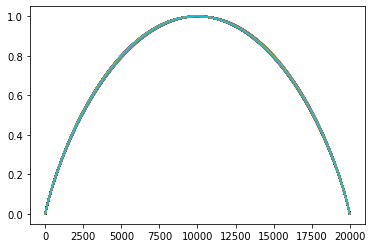

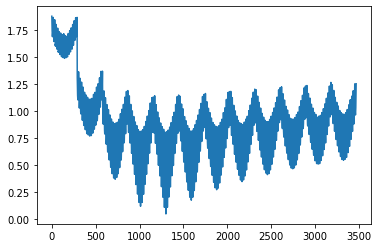

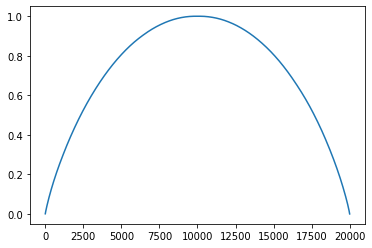

In [19]:
ns = 20000
x0 = jnp.array([1.1,0.3, -10]) # WHATEVER 
d = 3
b_zero = jnp.array([1.0, 0.0, 0.0])

betas1 = jnp.linspace(0.4, 2.2, 12) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-60, 60, 17)
betas3 = jnp.linspace(-60, 60, 17)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'ct'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()




In [20]:
betas_list = [betas1, betas2, betas3]
shape = [b.shape[0] for b in betas_list]
z = csaps(betas_list, g.reshape(shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)

hat_g = jnp.asarray(hg)

hatg_int = csaps(betas_list, hat_g.reshape(shape)) #

100%|██████████| 3468/3468 [01:14<00:00, 46.70it/s]


In [21]:
xs = np.linspace(0.5,1-1e-4,100)
r_our = lambda h: -xi(1-h)+xi(0.5)
# r_tss_bc= lambda h: 1/2*(xi(h) - xi(1-h))

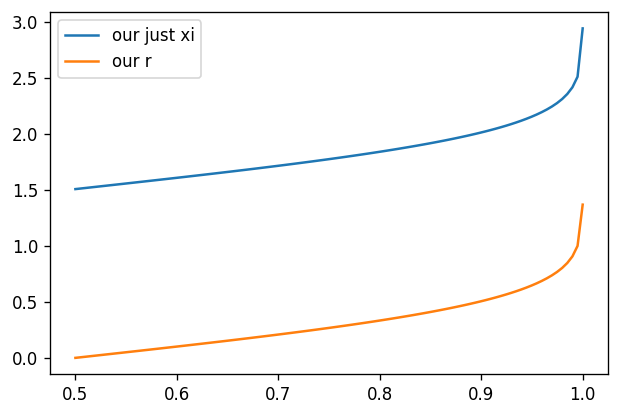

In [22]:
plt.figure(dpi=120)
plt.plot(xs, xi(xs), label='our just xi')
plt.plot(xs, r_our(xs), label='our r')
# plt.plot(xs, r_tss_bc(xs), '--', label='tss')
# plt.yscale('log')
plt.legend()
plt.show()


In [23]:
# checkpoint = torch.load('ReportResults/ContrasttTrans_08_40_checkpoint.pth.tar')
checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [24]:
# test_dataset = get_dataset('imagenet', 'test')
# pin_memory = False  # ('imagenet' == "imagenet")
# bs = 64


# testloader1 = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=6, pin_memory=False)


# ourdataset100 = make_our_dataset(testloader1, 100)

# dataloader100  = DataLoader(ourdataset100, shuffle=False, batch_size=1,
#                          num_workers=6, pin_memory=False)

In [25]:
iscor = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

  0%|          | 0/500 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 500/500 [00:07<00:00, 63.60it/s]

0.348


In [26]:
Phi = construct_phi(type_of_transform, device, sigma_c=sigma_c, sigma_tr=sigma_tr)
attack = attack_ct_torch

In [28]:
pas_ct = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive)
paCP, isOkCP = pas_ct # Clopper - Pearson

100%|██████████| 500/500 [09:24<00:00,  1.13s/it]


In [29]:
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

Ordinary accuracy of Smoothed Classiifer 0.298


(array([ 43.,  68., 127., 132.,  50.,  15.,  18.,  18.,  14.,  15.]),
 array([0.07379453, 0.16173982, 0.2496851 , 0.33763039, 0.42557567,
        0.51352096, 0.60146624, 0.68941153, 0.77735681, 0.8653021 ,
        0.95324738]),
 <BarContainer object of 10 artists>)

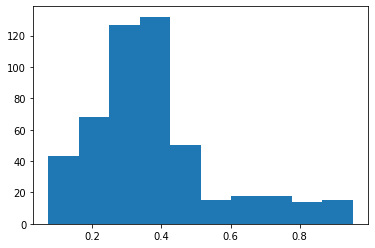

In [30]:
plt.hist(paCP)

In [42]:
betas1a = jnp.linspace(0.8, 1.2, 10) ## set a bit larger range than you want to certify
betas2a = jnp.linspace(-25, 25, 11)
betas3a = jnp.linspace(-25, 25, 11)
betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a))))



In [43]:
# hlist = [0.2, 0.5, 0.53,0.55, 0.6, 0.62, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8,0.83, 0.85, 0.87 ,0.9, 0.93]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 1210/1210 [00:01<00:00, 792.79it/s]

Cert Acc ct our 0.024 h_min is 0.7558528428093645


In [45]:
((paCP>hmin)).mean()

0.07

In [52]:
def make_accuracy_df_3D_to_2D_trans(betas, hs, correct, hatg_int, safe_beta = safe_beta,
                                    ifTSS = False, ifOURnew=False, extent = [0, 80.0, 0.5, 2.0], name = 'Certified accuracy for composition of Contrast and Translation'):
    beta_d = {'c': list(), 't1':list(), 't2':list()}
    accuracy = np.zeros(len(betas))

    for i, beta in enumerate(tqdm(betas)):
        beta_d['c'].append(beta[0])
        beta_d['t1'].append(beta[1])
        beta_d['t2'].append(beta[2])
        
        if ifOURnew:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1], beta[1])).item() * isOk) #, beta[2]
        elif ifTSS:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi_tss, h1, [*beta]).item() * isOk) #, beta[2]

        accuracy[i] /= len(correct)

    
    tn = []
    cs = []
    accs = []
    all_params = []

    for i, (c, t1, t2) in enumerate(zip(beta_d['c'], beta_d['t1'], beta_d['t2'])):
        t_norm = jnp.linalg.norm([t1, t2]).item()
        c_ = c.item()
        tn.append(t_norm)
        cs.append(c_)
        accs.append(accuracy[i])


    tns = []
    css = []
    acc_d = {}
    for x,y,z in zip(tn, cs, accs):
        if not x in tns:
            tns.append(x)
        if not y in css:
            css.append(y)
        acc_d[x,y] = z
        
    accdf = pd.DataFrame(data = jnp.array(list(acc_d.values())).reshape(len(css), len(tns)), index=css, columns=tns)
    accdf = accdf.reindex(sorted(accdf.columns), axis=1)
    clps = []
    for x in accdf.values:
        z = (np.asarray(list(map(np.array, x))))
        clps.append(z)

    plt.figure(figsize=(12,7))
    plt.imshow(clps, extent=extent, aspect='auto')
    #plt.set_ylabel([1., 11.])
    plt.title(name, fontsize=15)
    plt.xlabel(r'||v|| of translation parameter v', fontsize=15)
    plt.ylabel(r'$b$ contrast transform', fontsize=15)
    plt.colorbar();
    if ifOURnew:
        plt.savefig(dirname+'ct_our.png')
    else:
        plt.savefig(dirname+'ct_tss.png')
    return accdf, clps, acc_d

In [54]:
# accdf, clps, acc_d = make_accuracy_df_3D_to_2D_trans(betas, paCP, isOkCP, hatg_int, safe_beta = safe_beta, ifTSS = False, ifOURnew=True, extent = [0, 80.0, 0.5, 2.0])



# min(list(acc_d.values()))

# Contrast + Brightnest + Translation

In [46]:
sigma_tr = 50
sigma_c = 0.8
sigma_b = 0.8

100%|██████████| 1225/1225 [02:13<00:00,  9.19it/s]


(1225, 10000)
(1225,)
(10000,)


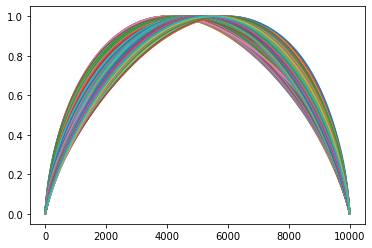

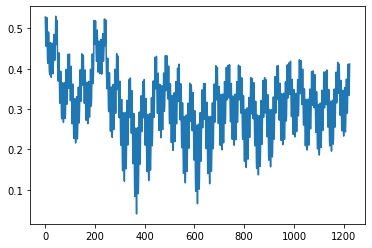

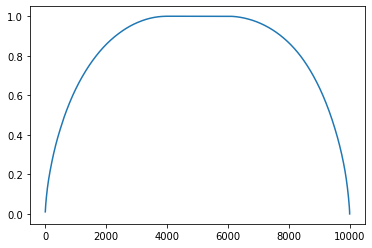

100%|██████████| 1225/1225 [00:29<00:00, 41.58it/s]


In [47]:
ns = 10000
x0 = jnp.array([0.0,0.0, 3., 21])
d = 4
b_zero = jnp.array([1.0, 0.0, 0.0, 0.0])

betas1 = jnp.linspace(0.7, 1.6, 5)
betas2 = jnp.linspace(-0.3, 0.3, 5)
betas3 = jnp.linspace(-30.0, 30.0, 7).astype(int)# * 1.0 # set more steps
betas4 = jnp.linspace(-30.0, 30.0, 7).astype(int) * 1.0
betas_list = [betas1, betas2, betas3, betas4]
type_of_transform = 'cbt'

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4)))) 

bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

shape = [b.shape[0] for b in betas_list]
z = csaps(betas_list, g.reshape(shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)

hat_g = jnp.asarray(hg)

hatg_int = csaps(betas_list, hat_g.reshape(shape)) #


In [48]:
checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [49]:
Phi = construct_phi(type_of_transform, device, sigma_c=sigma_c, sigma_b=sigma_b, sigma_tr=sigma_tr)
attack = attack_cbt_torch

In [50]:
pas_cbt = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive)
paCP, isOkCP = pas_cbt # Clopper - Pearson

100%|██████████| 500/500 [09:19<00:00,  1.12s/it]


In [51]:
betas1a = jnp.linspace(0.8, 1.5, 5)
betas2a = jnp.linspace(-0.2, 0.2, 5)
betas3a = jnp.linspace(-25.0, 25.0, 5).astype(int) * 1.0 # set more steps
betas4a = jnp.linspace(-25.0, 25.0, 5).astype(int) * 1.0

betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a, betas4a)))) 

In [52]:
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

Ordinary accuracy of Smoothed Classiifer 0.314


In [53]:
# hlist = [0.2, 0.5, 0.53,0.55, 0.6, 0.62, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8,0.83, 0.85, 0.87 ,0.9, 0.93]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 625/625 [00:00<00:00, 727.88it/s]

Cert Acc cbt our 0.02 h_min is 0.7090301003344481


In [54]:
cert_acc_cbt = cert_acc_within_betas_bounds

# TRANS BLUR BRIGHT CONTRAST

In [55]:
sigma_tr = 30
sigma_blur = 4
sigma_b = 0.8
sigma_c = 0.8

In [56]:
ns = 10000
x0 = jnp.array([1.0,3.0, 3., 1, 1.1]) # WHATEVER 
d = 5
b_zero = jnp.array([0.0, 0.0, 0.0,0.0, 1.0])

betas1 = jnp.linspace(-5, 5, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-5, 5, 5)
betas3 = jnp.linspace(0, 3, 6)
betas4 = jnp.linspace(-0.2, 0.2, 5)
betas5 = jnp.linspace(0.9, 1.1, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 



type_of_transform = 'tbbc_ray'
bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)


100%|██████████| 3750/3750 [07:29<00:00,  8.34it/s]


(3750, 10000)
(3750,)
(10000,)


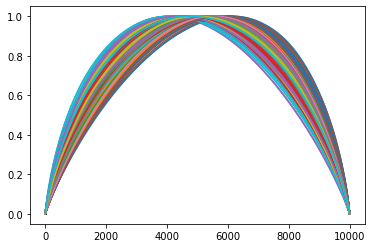

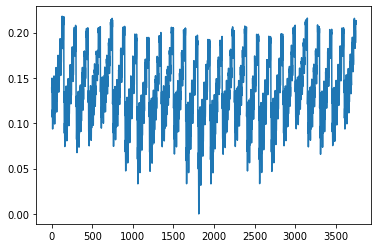

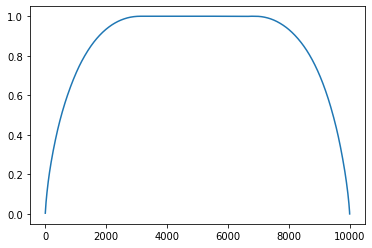

In [57]:
for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

In [58]:
z = csaps([betas1, betas2, betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) # interpolate


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3, betas4, betas5], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) #intterpolation of Integral g(beta)

100%|██████████| 3750/3750 [08:40<00:00,  7.21it/s]


In [63]:
import cv2 
import math

class Gaussian:
    # it adopts uniform distribution
    def __init__(self, sigma):
        self.sigma = sigma
        self.sigma2 = sigma ** 2.0

    def gen_param(self):
        r = random.uniform(0.0, self.sigma2)
        return r

    def proc(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
        input = input.cpu().numpy()
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        return out #.cuda()
    
    def proc_new(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
#         print(input.shape)
        input = input.cpu().numpy()
#         print(input.shape)
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        
        return out #.cuda()

    def batch_proc(self, inputs):
        outs = torch.zeros_like(inputs)
        for i in range(len(inputs)):
            outs[i] = self.proc(inputs[i], self.gen_param())
        return outs
    
class ExpGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(ExpGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.exponential(scale=self.sigma)
        r = r#.to(device)
        return r
    
class RayGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(RayGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.rayleigh(scale=self.sigma)
        return r
    

[autoreload of cv2.load_config_py3 failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.8/importlib/__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'cv2' not in sys.modules
]
[autoreload of cv2.data failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/p

In [64]:
def norm_to_exp_torch(s, lam):
    norm1 = torch.randn(s)
    norm2 = torch.randn(s)
    norm3 = torch.randn(s)
    norm4 = torch.randn(s)
    return torch.abs(norm1 * norm2 - norm3 * norm4) / lam
    

In [65]:
def attack_blur_cv2(x, b):
    r = b 
    input = x[0].cpu().numpy()
    r = r.item()
    out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), np.sqrt(r), borderType=cv2.BORDER_REFLECT101)
    out = torch.from_numpy(out.transpose(2, 0, 1))
    return out[None, :].to(device)
    

def phi_blur_torch_batch_and_noise(x, sigma_blur = sigma_blur):
    
    if not exp_smoothing:
        norm1 = torch.randn(len(x))
        norm2 = torch.randn(len(x))
        ray = torch.sqrt(norm1**2 + norm2**2)
        exp = ray ** 2
        blur_radii = sigma_blur * exp
    else:
        blur_radii = norm_to_exp_torch(len(x), sigma_blur)

#     blur_radii = sigma_blur * norm_to_exp_torch(torch.randn(len(x)))
    for i in range(len(x)):
        x[i] = attack_blur_cv2(x[i][None, :], blur_radii[i])
    return x.to(device)

In [66]:
def attack_tbbc_torch(x, b):  # tr bl br c

    x = x.to(device)
    translation = torch.tensor([[b[0].item(), b[1].item()]]).to(torch.float).to(device) 
    x = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    x = attack_blur_cv2(x, b = b[2])
    x = x + torch.tensor(b[3].item())
    x = torch.tensor(b[4].item())*x
    return x



def phi_tbbc_torch_batch_and_noise(x): 
    x = x.to(device)
    
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    x = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    
    x = phi_blur_torch_batch_and_noise(x)
    if exp_smoothing:
        blur = ExpGaussian(sigma_blur)
    else:
        blur = RayGaussian(sigma_blur)
    x = blur.batch_proc(x)
    
    b = (torch.randn(len(x)) * sigma_b)[:, None, None, None].to(device)
    x = x + b
    
    c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = c * x
    
    return x

In [67]:
checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar')
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [68]:
exp_smoothing = False

In [69]:
betas1a = jnp.linspace(-3, 3, 5) ## set a bit larger range than you want to certify
betas2a = jnp.linspace(-3, 3, 5)
betas3a = jnp.linspace(1, 3, 3)
betas4a = jnp.linspace(-0.1, 0.1, 7)
betas5a = jnp.linspace(0.95, 1.05, 5)
betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a, betas4a, betas5a)))) 

In [70]:
Accuracy(model, dataloader100, device)
# 0.65

100%|██████████| 500/500 [00:06<00:00, 77.66it/s]

0.348


array([[False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [

In [71]:
Phi = phi_tbbc_torch_batch_and_noise
attack = attack_tbbc_torch

In [72]:
pas_tbbc = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive)
paCP, isOkCP = pas_tbbc # Clopper - Pearson

100%|██████████| 500/500 [3:12:39<00:00, 23.12s/it]  


In [73]:
hlist = np.linspace(0.5, 1, 101)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 2625/2625 [00:14<00:00, 179.60it/s]

Cert Acc tbbc_ray our 0.202 h_min is 0.6


In [90]:
# for exponential smoothing TSS has the result

$\tilde{p}_A>1-\exp \left(-\lambda_B \alpha_B\right)\left(1-\Phi\left(\sqrt{\frac{\alpha_k^2}{\sigma_k^2}+\frac{\alpha_b^2}{e^{-2 \alpha_k} \sigma_b^2}+\frac{\alpha_{T x}^2+\alpha_{T y}^2}{\sigma_T^2}}\right)\right) .$

In [74]:
# sigma_b = 0.3
# sigma_c = 0.3
# sigma_tr = 10
# sigma_blur = 3
# safe_beta_tss(xi, h, [*beta]).item():
def safe_beta_tss_tbbc(xi, h, bs):
    Tx = bs[0]
    Ty = bs[1]
    B = bs[2]
    b = bs[3]
    k = np.log(bs[4])
    q = k**2/sigma_c**2 + b**2/(np.exp(-2*k) * sigma_b**2) + (Tx**2+Ty**2)/(sigma_tr**2)
    q = scipy.stats.norm.cdf(q)
    q = 1-q
    sb = 1  # sigma_blur
    q1 = np.exp(-B/sigma_blur)
    
    return h>(1-q1*q)
    
    

In [75]:
xi_tss = scipy.stats.norm.ppf

In [76]:
hlist = np.linspace(0.5, 1, 101)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_tbbc)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 2625/2625 [00:03<00:00, 713.20it/s]

Cert Acc CB TSS 0.142 h_min is 0.775


In [ ]:
2-2